# Installs and Imports

## Basic Imports

In [1]:
%%capture
import os
import sys
import IPython
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

## Vocoder Imports

In [ ]:
%%capture
!pip install parallel_wavegan
!pip install h5py=='3.6.0'
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [ ]:
from parallel_wavegan.utils import load_model
from parallel_wavegan.utils import read_hdf5
from parallel_wavegan.bin.preprocess import logmelfilterbank
import yaml

## TTS Imports

In [ ]:
sys.path.insert(1, '/workspace/coqui-tts')
from TTS.config import load_config, register_config
from TTS.tts.models import setup_model
from TTS.tts.models.forward_tts import ForwardTTS
from TTS.tts.models.styleforward_tts import StyleforwardTTS
from TTS.utils.audio import AudioProcessor
from TTS.tts.utils.synthesis import synthesis
from TTS.tts.utils.speakers import SpeakerManager
from TTS.tts.utils.styles import StyleManager
from TTS.tts.utils.visual import plot_spectrogram
from TTS.trainer import Trainer, TrainingArgs
from TTS.tts.datasets import load_tts_samples

## UMAP Imports

In [ ]:
%%capture
! pip install umap-learn
import umap
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Load Model and Set Device

In [8]:
%%capture

# MODEL AND DEVICE SELECTION
run_name = "re+class"           
run_select = "last_checkpoint"
device = "cpu"
synthesizer = "hifi-gan" # hifi-gan or griffin-limm
use_cuda = True if device == "cuda" else False

# CHECKPOINTS
checkpoints_dict = {
                   # Neutral Models (Speaker Look-Up)
                   "vctk":{"last_checkpoint":"model_file.pth.tar"},
                   "neutral":{"last_checkpoint":"checkpoint_1080000.pth.tar", "part":"neutral"},
                   "neutral-lj":{"last_checkpoint":"checkpoint_1080000.pth.tar", "part":"neutral"},
    
                   # Style Finetunings (Speaker Look-Up)
                   "amused":{"last_checkpoint":"checkpoint_1113000.pth.tar", "part":"amused"},
                   "angry":{"last_checkpoint":"checkpoint_1121000.pth.tar", "part":"angry"},
                   "disgusted":{"last_checkpoint":"checkpoint_1097000.pth.tar", "part":"disgusted"},
                   "sleepy":{"last_checkpoint":"checkpoint_1036000.pth.tar", "part":"Sleepy"},
    
                   # Speaker Finetunings (Style Look-Up)
                   "sam":{"last_checkpoint": "checkpoint_1390000.pth.tar", "part":"sam"},
                   "josh":{"last_checkpoint": "checkpoint_1150000.pth.tar", "part":"josh"},
                   "jenie":{"last_checkpoint": "checkpoint_1160000.pth.tar", "part":"jenie"},
                   "bea":{"last_checkpoint": "checkpoint_1130000.pth.tar", "part":"bea"},
    
                   # Multi-Speaker Multi-Style (Double Look-Up)
                   "double_lookup":{"last_checkpoint": "checkpoint_1240000.pth.tar", "part":"all"},
    
                   # Representation Learning
                   "re":{"last_checkpoint": "checkpoint_1240000.pth.tar", "part":"all"},
                   "re+class":{"last_checkpoint": "checkpoint_1240000.pth.tar", "part":"all"},
                   "lj-re+class":{"last_checkpoint": "checkpoint_1250000.pth.tar", "part":"all"},
                   "re+class+grl":{"last_checkpoint": "checkpoint_1270000.pth.tar", "part":"all"},
                    }

# EXPERIMENT FOLDER
folder = "../experiments/" + run_name + "/"

# LOAD CONFIG
config = load_config(folder + "config.json")

# LOAD SPEAKERS
if os.path.isfile(folder + "speakers.json"):
    spk_file_path = folder + "speakers.json"
    spk_manager = SpeakerManager(speaker_id_file_path = spk_file_path)
    with open(spk_file_path) as json_file:
        spk_to_id = json.load(json_file)
else:
    spk_to_id = {}
    spk_manager = None
    
# LOAD STYLES
if os.path.isfile(folder + "style_ids.json"):
    sty_file_path = folder + "style_ids.json"
    sty_manager = StyleManager(style_ids_file_path = sty_file_path)
    with open(sty_file_path) as json_file:
        sty_to_id = json.load(json_file)
else:
    sty_to_id = {}
    sty_manager = None
    
# LOAD MODEL        
model = setup_model(config, speaker_manager = spk_manager, style_manager = sty_manager)

# LOAD CHECKPOINT
checkpoint = torch.load(folder + checkpoints_dict[run_name][run_select], map_location=torch.device(device))['model']
model.load_state_dict(checkpoint)

# PREPARE MODEL
model.to(device)
model.eval()

# PREPARE VOCODER
if synthesizer != "griffin-limm":
    voc_name = synthesizer
    voc_checkpoint = "../experiments/vocoders/" + voc_name + "/checkpoint-470000steps.pkl"
    voc_config_path = "../experiments/vocoders/" + voc_name + "/config.yml"
    voc_stats = "../experiments/vocoders/" + voc_name + "/stats.h5"
    with open(voc_config_path) as f:
        voc_config = yaml.load(f, Loader = yaml.Loader)
    vocoder = load_model(voc_checkpoint, voc_config)
    vocoder.to(device)
    vocoder.eval()
    vocoder.remove_weight_norm()
    
    # CHECK COMPATIBILITY WITH TTS
    config.audio.log_func = 'np.log10'
    assert voc_config['sampling_rate'] == config.audio.sample_rate
    assert voc_config['fmax'] == config.audio.mel_fmax
    assert voc_config['fmin'] == config.audio.mel_fmin
    assert voc_config['fft_size'] == config.audio.fft_size
    assert voc_config['hop_size'] == config.audio.hop_length
    assert voc_config['win_length'] == config.audio.win_length
else:
    pass


# Audio Processor
ap = AudioProcessor(**config.audio)

# Audios

Outputs audios of the synthesis, ressynthesis and ground-truths.

In [9]:
def read_metadata(dataset, sub):
    # Get csv
    df = pd.read_csv("../recipes/emovdb/emovdb/" + "metadata/metadata_"+ dataset + "_" + sub + ".csv", sep = "\n", header=None)
    lines = [item for sublist in df.values.tolist() for item in sublist]
    if 'lj' in run_name:
        if dataset == 'test':
            dataset = 'val'
        df_lj = pd.read_csv("../recipes/ljspeech/LJSpeech-1.1/" + "metadata/metadata_" + dataset + "_reduced.csv", sep = "\n", header=None)
        lines_lj = [item for sublist in df_lj.values.tolist() for item in sublist]
    # Parse csv
    file_names = []
    texts = []
    spks = []
    styles = []
    for line in lines:
        file_names.append('../recipes/emovdb/emovdb/files/'+ line.split(sep='|')[0])
        texts.append(line.split(sep='|')[1])
        spks.append(line.split(sep='|')[2])
        styles.append(line.split(sep='|')[3])
    if 'lj' in run_name:
        for line in lines_lj:
            file_names.append('../recipes/ljspeech/LJSpeech-1.1/wavs/'+ line.split(sep='|')[0] + '.wav')
            texts.append(line.split(sep='|')[1])
            spks.append('ljspeech')
            styles.append('Neutral')
    return {'texts':texts, 'speakers':spks, 'styles':styles, 'style_wavs':file_names}

## Synthesis

In [21]:
# Fetch Inputs
dataset = "test"
partition = checkpoints_dict[run_name]["part"]
data = read_metadata(dataset,partition)
idx = 3

# Or Insert directly
#text = "An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds."
#speaker = 'sam'
text =  data['texts'][idx]
speaker = data['speakers'][idx]
#style = data['styles'][idx]
#style_wav = data['style_wavs'][0]
style_representation = np.load('centroids_re+class.npy', allow_pickle=True).item()['Angry'].to('cpu')

# SYNTHESIS
if synthesizer == "griffin-limm":
    out = synthesis(use_griffin_lim=True, text = text,model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
else:
    fp_out = synthesis(text = text, model = model,  style_representation = style_representation, speaker_id = spk_to_id.get(speaker),  CONFIG = config, use_cuda = use_cuda, ap = ap)
    feat_gen_denorm = torch.Tensor(fp_out['outputs']['model_outputs'].cpu().numpy()[0]).cuda()
    feat_gen_denorm = torch.log10(torch.exp(feat_gen_denorm))
    feat_gen_norm = (feat_gen_denorm.cpu() - torch.from_numpy(read_hdf5(voc_stats, "mean"))) / torch.from_numpy(read_hdf5(voc_stats, "scale"))
    out = {'wav':vocoder.inference(feat_gen_norm).cpu().detach().numpy().squeeze(1)}

# RESULTS
audio_syn = out['wav']
print("Text = {}".format(text))
print("Spk = {}".format(speaker))
#print("Sty = {}".format(style))
#print("Sty_Wav = {}".format(style_wav))
#print("Sty_Rep = {}".format(style_representation))
IPython.display.Audio(audio_syn, rate=config.audio.sample_rate)

Text = Three oilers and a fourth engineer, was his greeting.
Spk = sam


## GT Resynthesis

In [22]:
gt_wav = ap.load_wav(data['style_wavs'][idx])
gt_spectrogram = ap.melspectrogram(gt_wav)

if synthesizer == 'griffin-limm':
    res_wav = ap.inv_melspectrogram(gt_spectrogram)
else:
    feat_gen_denorm = torch.Tensor(gt_spectrogram.T).cuda()
    feat_gen_norm = (feat_gen_denorm.cpu() - torch.from_numpy(read_hdf5(voc_stats, "mean"))) / torch.from_numpy(read_hdf5(voc_stats, "scale"))
    res_wav = vocoder.inference(feat_gen_norm).cpu().detach().numpy().squeeze(1)
res_spectrogram = ap.melspectrogram(res_wav)

# PLAY GT+RES
IPython.display.Audio(res_wav, rate=config.audio.sample_rate)

## GT

In [23]:
IPython.display.Audio(gt_wav, rate=config.audio.sample_rate)

# Mel-Spectrograms

Outputs images of mel-spectrograms.

## Synthesis

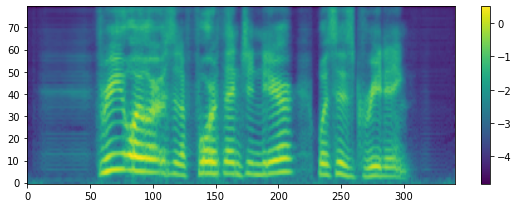

In [24]:
# PLOT GT MEL-SPECTROGRAM
plot_spectrogram(ap.melspectrogram(audio_syn).T, ap, fig_size=(8,3))

## GT Resynthesis

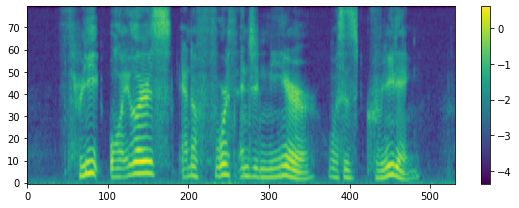

In [25]:
# PLOT GT+RES MEL-SPECTROGRAM
plot_spectrogram(res_spectrogram.T, ap, fig_size=(8,3))

## GT

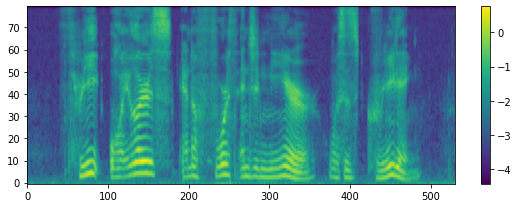

In [130]:
# PLOT GT MEL-SPECTROGRAM
plot_spectrogram(gt_spectrogram.T, ap, fig_size=(8,3))

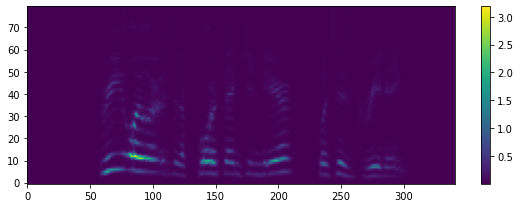

In [177]:
plot_spectrogram(ap._db_to_amp(ap.denormalize(ap.melspectrogram(audio_syn).T)), ap, fig_size=(8,3))

# Pitch, Energy, Duration

# UMAP

Outputs style spaces and style representations.

## Setup

In [8]:
#### FUNCTIONS ####

def numpy_to_torch(np_array, dtype, cuda=False):
    if np_array is None:
        return None
    tensor = torch.as_tensor(np_array, dtype=dtype)
    if cuda:
        return tensor.cuda()
    return tensor


# dict style2id
map_style = {
    'Amused': 0,
    'Angry': 1,
    'Disgusted': 2,
    'Neutral': 3,
    'Sleepy': 4
}

# dict style2id
map_id2style = {
    0:'Amused',
    1:'Angry',
    2:'Disgusted',
    3:'Neutral',
    4:'Sleepy' 
}

def map_wavpath2style(wav_path):
    if('Amused' in wav_path):
        return 'Amused'
    elif('Angry' in wav_path):
        return 'Angry'
    elif('Disgusted' in wav_path):
        return 'Disgusted'
    elif('Neutral' in wav_path):
        return 'Neutral'
    elif ('LJ' in wav_path):
        return 'Neutral'
    elif('Sleepy' in wav_path):
        return 'Sleepy'
    else:
        return 'none'

# dict style2id
map_speaker = {
    'jenie': 0,
    'bea': 1,
    'sam': 2,
    'josh': 3,
    'ljspeech':4,
}

# dict style2id
map_id2speaker = {
    0:'jenie',
    1:'bea',
    2:'sam',
    3:'josh',
    4:'ljspeech',
}

def map_wavpath2speaker(wav_path):
    if('jenie' in wav_path):
        return 'jenie'
    elif('bea' in wav_path):
        return 'bea'
    elif('sam' in wav_path):
        return 'sam'
    elif('josh' in wav_path):
        return 'josh'
    elif('LJ' in wav_path):
        return 'ljspeech'
    else:
        return None

In [9]:
#### DATASET DEFINITIONS ####

config.datasets[0].path = '../recipes/emovdb/emovdb'
test = '../recipes/emovdb/emovdb/metadata/metadata_train_all.csv'
test = pd.read_csv(test, delimiter='|', encoding= 'utf-8', header=None, names = ['wav_path', 'text', 'speaker', 'style']) 
div = len(test)

if 'lj' in run_name:
    config.datasets[1].path = '../recipes/ljspeech/LJSpeech-1.1'
    test2 = '../recipes/ljspeech/LJSpeech-1.1/metadata_train_reduced.csv'
    test2 = pd.read_csv(test2, delimiter='|', encoding= 'utf-8', header=None, names = ['wav_path', 'text', 'speaker', 'style']).assign(style = 'Neutral').assign(speaker = 'ljspeech')
    test = test.append(test2, ignore_index=True)    

#### TRAINER ####

# init trainer args
train_args = TrainingArgs()

# load training samples
train_samples, eval_samples = load_tts_samples(config.datasets, eval_split=True)

# init speaker manager
if config.use_speaker_embedding:
    speaker_manager = SpeakerManager(data_items=train_samples + eval_samples)
elif config.use_d_vector_file:
    speaker_manager = SpeakerManager(d_vectors_file_path=config.d_vector_file)
else:
    speaker_manager = None

# init style manager
if config.style_encoder_config.use_supervised_style:
    style_manager = StyleManager(data_items=train_samples + eval_samples)
    if hasattr(config, "model_args"):
        config.model_args.num_styles = style_manager.num_styles
    else:
        config.num_styles = style_manager.num_styles
else:
    style_manager = None
    
# init the model from config
language_manager = None
model = setup_model(config, speaker_manager, language_manager, style_manager)

# init the trainer
trainer = Trainer(
    train_args,
    config,
    config.output_path,
    model=model,
    train_samples=train_samples,
    eval_samples=eval_samples,
    training_assets={"audio_processor": ap},
    parse_command_line_args=False,
)

# restore checkpoint
checkpoint = folder + checkpoints_dict[run_name]['last_checkpoint']
trainer.model, opt, scaler, restore_step = trainer.restore_model(config, checkpoint, trainer.model, trainer.optimizer, trainer.scaler)

# extract representations
use_cuda = True

N = config['style_encoder_config']['style_embedding_dim']

syn_embs = np.zeros((len(test), N))
ressyn_embs = np.zeros((len(test), N))

styles = []
speakers = []
wavs = []

for i in tqdm(range(len(test))):
    
    # Model Inputs
    text = test.text.values[i]
    speaker = test.speaker.values[i]
    if i < div:
        style_wav = '../recipes/emovdb/emovdb/files/' + test.wav_path.values[i]
    else:
        style_wav = '../recipes/ljspeech/LJSpeech-1.1/wavs/' + test.wav_path.values[i]

    # Embeddings for synthesis
    fp_out = synthesis(text = text, speaker_id = spk_to_id.get(speaker), style_wav=style_wav, model = model, CONFIG = config, use_cuda = use_cuda, ap = ap)
    syn_embs[i] = fp_out['outputs']['style_encoder_outputs']['style_embedding'].squeeze(0).squeeze(0).detach().cpu().numpy()
    
    # Get synthesized spectrogram
    #syn_mel = fp_out['outputs']['model_outputs'].cpu().numpy()[0]
    #style_mel = numpy_to_torch(syn_mel, torch.float, cuda=use_cuda)[0].T
    
    # Ressynthesized embeddings
    #style_encoder_outputs = model.cuda().style_encoder_layer.forward([torch.rand(1,384,1).cuda(),style_mel.unsqueeze(0)])
    #ressyn_embs[i] = style_encoder_outputs['style_embedding'].squeeze(0).squeeze(0).detach().cpu().numpy()
    
    # Save Info
    styles.append(map_style[map_wavpath2style(test.wav_path.values[i])])
    speakers.append(map_speaker[map_wavpath2speaker(test.wav_path.values[i])])
    wavs.append(style_wav)

 | > Found 6755 files in /workspace/coqui-tts/recipes/emovdb/emovdb
{'Amused': 0, 'Angry': 1, 'Disgusted': 2, 'Neutral': 3, 'Sleepy': 4}
 > Using model: stylefast_pitch
 > Init speaker_embedding layer.
 > using STYLE information.
Using style guided training with 5 styles
 > Using CUDA:  True
 > Number of GPUs:  1
 > `speakers.json` is saved to /workspace/coqui-tts/experiments/re/neutral_ft_RE-February-24-2023_01+35AM-053d2f1f/speakers.json.
 > `speakers_file` is updated in the config.json.
 > `style_ids.json` is saved to /workspace/coqui-tts/experiments/re/neutral_ft_RE-February-24-2023_01+35AM-053d2f1f/style_ids.json.
 > `style_ids_file` is updated in the config.json.

 > Model has 38695239 parameters
 > Restoring from checkpoint_1240000.pth.tar ...
 > Restoring Model...
 > Restoring Optimizer...



  0%|                                                                                                         | 0/6755 [00:00<?, ?it/s]

 > Model restored from step 1240000


100%|████████████████████████████████████████████████████████████████████████████████████████████| 6755/6755 [1:21:09<00:00,  1.39it/s]


[[9.958461 4.011329]]
[[10.757275   2.0122998]]
[[6.227951  1.7053885]]
[[6.2403755 3.870623 ]]
[[2.5346906 3.4875464]]
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = i am so angry right now
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter storm will produce multiple rounds of heavy snowfall and strong winds
Text = An unusually cold winter s

## Style Space

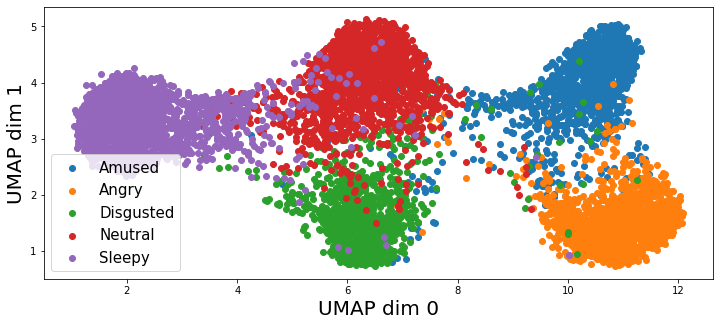

In [15]:
# FIT / TRANSFORM UMAP
#u = umap.UMAP(random_state = 42)
#embeddings = u.fit_transform(syn_embs)
embeddings = u.transform(syn_embs)

# Creating dataframe to better manipulate
df = pd.DataFrame({'wavs': wavs, 'style': styles, 'speaker': speakers, 'dim1': embeddings[:,0], 'dim2': embeddings[:,1]})

# Plot
%matplotlib inline
plt.figure(figsize=(12,5))
for i in range(5):
    df_filt = df[df['style'] == i]
    # df_filt = df_filt[df_filt['speaker']==4]
    plt.scatter(df_filt['dim1'], df_filt['dim2'], label = map_id2style[i])
plt.legend(fontsize=15)
plt.xlabel('UMAP dim 0', fontsize = 20)
plt.ylabel('UMAP dim 1', fontsize = 20)
plt.show()

## Extract Centroid Representation

In [12]:
centroids = {}
for i in range(len(map_id2style)):
    style_centroid = map_id2style[i]
    idxs = df[df['style']== map_style[style_centroid]].index.tolist()
    style_representations = syn_embs[idxs]
    centroid = style_representations.mean(axis=0)
    print(u.transform(centroid.reshape(1,-1)))
    style_representation = torch.Tensor(centroid).unsqueeze(0).to('cuda:0')
    centroids[style_centroid] = style_representation
with open('centroids_' + run_name + '.npy', 'wb') as f:
    np.save(f, centroids)
    
# Representation to UMAP u.transform(centroids['style'].reshape(1,-1))

In [406]:
u.transform(centroids['Sleepy'].reshape(1,-1).to(device))

array([[2.5346906, 3.4875464]], dtype=float32)

In [399]:
u.transform(syn_embs[5118].reshape(1,-1))

array([[0.86741537, 3.3160403 ]], dtype=float32)

In [416]:
df[df['style']==4][df[df['style']==4]['dim2'].between(0,2.25)].sort_values(by='dim2')

,wavs,style,speaker,dim1,dim2
6509,../recipes/emovdb/emovdb/files/sam_Sleepy/slee...,4,2,10.011218,0.930995
1207,../recipes/emovdb/emovdb/files/josh_Sleepy/sle...,4,3,6.007378,1.015360
6258,../recipes/emovdb/emovdb/files/josh_Sleepy/sle...,4,3,5.821116,1.062523
1217,../recipes/emovdb/emovdb/files/josh_Sleepy/sle...,4,3,6.690473,1.110853
1581,../recipes/emovdb/emovdb/files/jenie_Sleepy/sl...,4,0,6.656995,1.248179
2598,../recipes/emovdb/emovdb/files/sam_Sleepy/slee...,4,2,5.126950,1.871207
5862,../recipes/emovdb/emovdb/files/jenie_Sleepy/sl...,4,0,5.231919,2.094946


In [392]:
wav = df[df['style']==4].loc[1284].wavs

In [393]:
IPython.display.Audio(ap.load_wav(wav), rate=config.audio.sample_rate)

In [120]:
a = torch.FloatTensor([1.,2.,3.]).requires_grad_()

In [105]:
c = torch.stack((a,b), dim = 1)

In [121]:
a

tensor([1., 2., 3.], requires_grad=True)

In [122]:
b = a.detach().clone().requires_grad_(True)

In [129]:
#b.reshape(3,1).repeat(1,3).flatten()
b.reshape(3,1).repeat(1,2).flatten()

tensor([1., 1., 2., 2., 3., 3.], grad_fn=<ReshapeAliasBackward0>)

In [89]:
c = torch

tensor([1., 2., 3.], requires_grad=True)